In [1]:
#%pip install -U "autogen-agentchat"
#%pip install -U "autogen-agentchat[azure]"
#%pip install -U autogenstudio



# Example using the ROUND ROBIN GROUPCHAT team

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
import yaml


## with o4-mini reasoning model

In [3]:
with open("model_config_reasoning_model.yaml", "r") as f:
        model_config = yaml.safe_load(f)
model_client = AzureOpenAIChatCompletionClient.load_component(model_config)

In [4]:
#%pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4


In [5]:
def google_search_tool(query: str, num_results: int = 2, max_chars: int = 500) -> list:  # type: ignore[type-arg]
    import os
    import time

    import requests
    from bs4 import BeautifulSoup
    from dotenv import load_dotenv

    load_dotenv()

    api_key = os.getenv("GOOGLE_API_KEY")
    search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")

    if not api_key or not search_engine_id:
        raise ValueError("API key or Search Engine ID not found in environment variables")

    url = "https://customsearch.googleapis.com/customsearch/v1"
    params = {"key": str(api_key), "cx": str(search_engine_id), "q": str(query), "num": str(num_results)}

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(response.json())
        raise Exception(f"Error in API request: {response.status_code}")

    results = response.json().get("items", [])

    def get_page_content(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            words = text.split()
            content = ""
            for word in words:
                if len(content) + len(word) + 1 > max_chars:
                    break
                content += " " + word
            return content.strip()
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return ""

    enriched_results = []
    for item in results:
        body = get_page_content(item["link"])
        enriched_results.append(
            {"title": item["title"], "link": item["link"], "snippet": item["snippet"], "body": body}
        )
        time.sleep(1)  # Be respectful to the servers

    return enriched_results




In [6]:
def stock_analysis_tool(ticker: str) -> dict:  # type: ignore[type-arg]
    import os
    from datetime import datetime, timedelta

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from pytz import timezone  # type: ignore

    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result


In [7]:
search_agent = AssistantAgent(
    name="Google_Search_Agent",
    model_client=model_client,
    tools=[google_search_tool],
    description="Search Google for information, returns top 2 results with a snippet and body content",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = AssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=model_client,
    tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="Perform data analysis.",
)

report_agent = AssistantAgent(
    name="Report_Agent",
    model_client=model_client,
    description="Generate a report based the search and results of stock analysis",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)


In [8]:
team = RoundRobinGroupChat([stock_analysis_agent, search_agent, report_agent], max_turns=3)


---------- TextMessage (user) ----------
Write a financial report on Microsoft
---------- ToolCallRequestEvent (Stock_Analysis_Agent) ----------
[FunctionCall(id='call_6WejOKvAR9PmvGUzZn4qrZ4M', arguments='{"ticker":"MSFT"}', name='stock_analysis_tool')]
Plot saved as coding/MSFT_stockprice.png
---------- ToolCallExecutionEvent (Stock_Analysis_Agent) ----------
[FunctionExecutionResult(content="{'ticker': 'MSFT', 'current_price': 391.85, '52_week_high': 468.35, '52_week_low': 344.79, '50_day_ma': 387.17262756347657, '200_day_ma': 414.2127503967285, 'ytd_price_change': -25.892364501953125, 'ytd_percent_change': -6.198165741345598, 'trend': 'Downward', 'volatility': 0.2490326768115015, 'plot_file_path': 'coding/MSFT_stockprice.png'}", name='stock_analysis_tool', call_id='call_6WejOKvAR9PmvGUzZn4qrZ4M', is_error=False)]
---------- ToolCallSummaryMessage (Stock_Analysis_Agent) ----------
{'ticker': 'MSFT', 'current_price': 391.85, '52_week_high': 468.35, '52_week_low': 344.79, '50_day_ma':

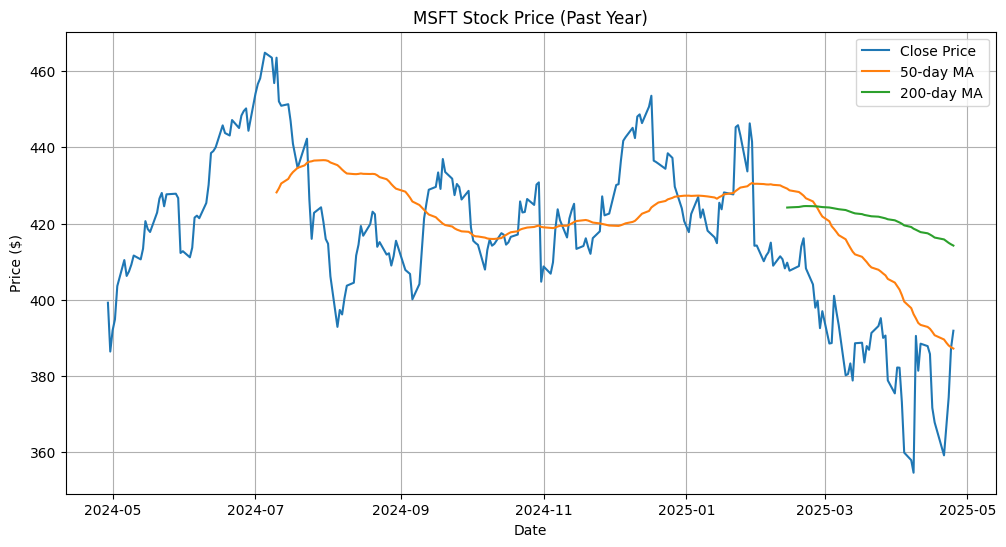

In [9]:
stream = team.run_stream(task="Write a financial report on Microsoft")
await Console(stream)

await model_client.close()
